In [1]:
import pandas as pd

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [10]:
pip install -U gensim


  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
Note: you may need to restart the kernel to use updated packages.


In [11]:
from gensim.corpora.dictionary import Dictionary

In [13]:
!pip install razdel

In [14]:
!pip install pymorphy2

  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13709 sha256=c76d71860ab6c4ca9581b8022f31f9501e70c81b72143be4c95fcfa059225044
  Stored in directory: c:\users\igora\appdata\local\pip\cache\wheels\56\ea\58\ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [15]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [20]:
import nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\igora\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [22]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [23]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [24]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [25]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-24-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 47.5 s


In [26]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 6min 10s


In [27]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [28]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [29]:
common_dictionary[10]

'ватутин'

In [30]:
from gensim.models import LdaModel

In [31]:
LdaModel?

In [32]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 1min 14s


In [33]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [34]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(12, 0.037388332), (18, 0.3470352), (20, 0.5958533)]

In [35]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: год банк рубль рак ставка россия доход
topic_1: компания млрд рынок конкурс экономика бизнес памятник
topic_2: век писать земля температура россия nn обращение
topic_3: дело уголовный сотрудник полиция задержать следствие статья
topic_4: источник это тело санкция мочь который способ
topic_5: ребёнок выяснить мозг женщина врач космос мужчина
topic_6: район граница остров экономический расчёт высота авария
topic_7: экипаж египет власть орган отряд доклад саммит
topic_8: взрыв страдать вирус сообщество пережить курение человек
topic_9: это год снижение экономика весь эксперимент время
topic_10: рекомендовать греция арабский звонок сибирский греческий шотландия
topic_11: белоруссия белорусский тепло брюссель разделение рисунок соотношение
topic_12: цена евро стоимость фонд письмо сообщество уточнять
topic_13: суд убийство дело решение иск следователь обвинение
topic_14: писать сон корея ким определение студия выдавать
topic_15: ракета погибнуть операция армия сша турция турецкий
t

In [36]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [37]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.301594,0.0,0.011771,0.000000,0.0,0.0,0.000000,0.175103,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.267464,0.0,0.236768
1,4896,0.000000,0.0,0.503505,0.259537,0.0,0.0,0.000000,0.000000,0.146907,...,0.0,0.068503,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000
2,4897,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.347056,0.0,0.595831,0.00000,0.000000,0.0,0.000000
3,4898,0.000000,0.0,0.089992,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.025023,0.000000,0.0,0.000000,0.18301,0.000000,0.0,0.000000
4,4899,0.000000,0.0,0.228175,0.000000,0.0,0.0,0.081979,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.361746,0.0,0.304731


In [38]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [39]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [40]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.        , 0.0505763 ,
       0.05318738, 0.        , 0.        , 0.        , 0.04154732,
       0.02962183, 0.        , 0.05896291, 0.        , 0.        ,
       0.        , 0.02055676, 0.06238798, 0.33967188, 0.0900828 ,
       0.        , 0.        , 0.24428996, 0.        , 0.        ])

In [59]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [60]:
get_user_embedding(user_articles_list)

array([0.05317369, 0.        , 0.00695466, 0.0892298 , 0.02356595,
       0.        , 0.00862251, 0.00728094, 0.        , 0.03384493,
       0.        , 0.        , 0.00719496, 0.03464241, 0.00191528,
       0.01533359, 0.        , 0.00367174, 0.27078644, 0.        ,
       0.00582347, 0.21524106, 0.20472617, 0.00175357, 0.00204499])

In [61]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.008509,0.019270,0.012235,0.018056,0.024179,0.005693,0.003500,0.004257,...,0.012607,0.003426,0.010398,0.322973,0.024162,0.000000,0.189688,0.229305,0.0,0.000000
1,u108690,0.017817,0.005707,0.020126,0.043870,0.022938,0.009432,0.020549,0.006777,0.000000,...,0.003105,0.000000,0.037275,0.401702,0.004232,0.016872,0.131301,0.156961,0.0,0.025353
2,u108339,0.050001,0.013010,0.023183,0.083523,0.026440,0.024874,0.032915,0.012764,0.000000,...,0.011008,0.000000,0.011064,0.199677,0.000000,0.000000,0.226169,0.159709,0.0,0.028959


In [44]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [62]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.008509,0.019270,0.012235,0.018056,0.024179,0.005693,0.003500,0.004257,...,0.003426,0.010398,0.322973,0.024162,0.000000,0.189688,0.229305,0.0,0.000000,0
1,u108690,0.017817,0.005707,0.020126,0.043870,0.022938,0.009432,0.020549,0.006777,0.000000,...,0.000000,0.037275,0.401702,0.004232,0.016872,0.131301,0.156961,0.0,0.025353,1
2,u108339,0.050001,0.013010,0.023183,0.083523,0.026440,0.024874,0.032915,0.012764,0.000000,...,0.000000,0.011064,0.199677,0.000000,0.000000,0.226169,0.159709,0.0,0.028959,1


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [63]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [64]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [65]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.30419313, 0.07942183, 0.32622991, 0.38135003, 0.01769574,
       0.1000049 , 0.0606614 , 0.12321252, 0.04077154, 0.14725514])

In [66]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

Рассчитаем Precision, Recall, F_score

In [51]:
import itertools

In [67]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.705101, F-Score=nan, Precision=0.000, Recall=0.000


<ipython-input-67-010bf5497cf3>:2: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


In [68]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1755    0]
 [ 245    0]]


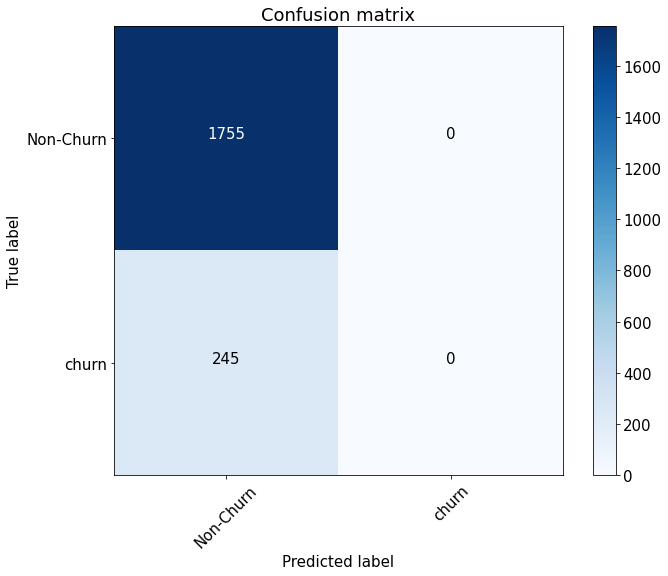

In [69]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [70]:
roc_auc_score(y_test, preds)

0.9209698238269667

**Медиана**

In [71]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding_med(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [72]:
get_user_embedding_med(user_articles_list)

array([0.01185752, 0.        , 0.        , 0.        , 0.01517362,
       0.        , 0.        , 0.        , 0.        , 0.02850539,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.25397911, 0.        ,
       0.        , 0.23714405, 0.14411272, 0.        , 0.        ])

In [73]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_med(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.319007,0.0,0.0,0.208030,0.195881,0.0,0.000000
1,u108690,0.009346,0.0,0.005289,0.000000,0.011745,0.00000,0.019014,0.005203,0.0,...,0.000000,0.0,0.018774,0.411066,0.0,0.0,0.111161,0.196321,0.0,0.017198
2,u108339,0.040243,0.0,0.000000,0.088525,0.009124,0.01014,0.032449,0.010069,0.0,...,0.006536,0.0,0.000000,0.220295,0.0,0.0,0.259810,0.104375,0.0,0.000000


In [74]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.000000,0.319007,0.0,0.0,0.208030,0.195881,0.0,0.000000,0
1,u108690,0.009346,0.0,0.005289,0.000000,0.011745,0.00000,0.019014,0.005203,0.0,...,0.0,0.018774,0.411066,0.0,0.0,0.111161,0.196321,0.0,0.017198,1
2,u108339,0.040243,0.0,0.000000,0.088525,0.009124,0.01014,0.032449,0.010069,0.0,...,0.0,0.000000,0.220295,0.0,0.0,0.259810,0.104375,0.0,0.000000,1


In [75]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [76]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.1570048 , 0.0723024 , 0.35593189, 0.36052788, 0.01163454,
       0.12617811, 0.01697245, 0.12695235, 0.03771771, 0.15256326])

In [77]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.754018, F-Score=nan, Precision=0.000, Recall=0.000


<ipython-input-77-010bf5497cf3>:2: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


In [78]:
roc_auc_score(y_test, preds)

0.9193162393162393

**MAX**

In [87]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [88]:
get_user_embedding_max(user_articles_list)

array([0.24346885, 0.        , 0.02543589, 0.53537881, 0.05592752,
       0.        , 0.05173506, 0.02462442, 0.        , 0.10129301,
       0.        , 0.        , 0.04316974, 0.20785445, 0.0114917 ,
       0.09200152, 0.        , 0.02203043, 0.59146172, 0.        ,
       0.03494084, 0.3049767 , 0.5149892 , 0.01052141, 0.01226992])

In [89]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [90]:
X = pd.merge(user_embeddings, target, 'left')

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [92]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.9765765 , 0.33071484, 0.45823667, 0.95868436, 0.03975803,
       0.26705075, 0.63394012, 0.46945673, 0.21044272, 0.53728829])

In [93]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.997272, F-Score=nan, Precision=0.000, Recall=0.000


<ipython-input-93-010bf5497cf3>:2: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


In [94]:
roc_auc_score(y_test, preds)

0.771658817373103

In [97]:
#roc_auc, precision, recall, f_score
itog = pd.DataFrame({'name': ['mean', 'median', 'max'], 'Best Threshold': [0.705101, 0.754018, 0.997272], 'F-Score': ['nan', 'nan', 'nan'], 'Precision':[0, 0, 0], 'Recall': [0, 0, 0], 'roc_auc_score': [0.9209698238269667, 0.9193162393162393, 0.771658817373103]})
itog

,name,Best Threshold,F-Score,Precision,Recall,roc_auc_score
0,mean,0.705101,nan,0,0,0.920970
1,median,0.754018,nan,0,0,0.919316
2,max,0.997272,nan,0,0,0.771659


использование медианы более устойчиво к выбрасам, по результатам практически одинаковый со средним.